In [57]:
import transformers, torch, pickle, os, numpy as np, matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import SiglipImageProcessor,SiglipModel, SiglipTokenizer, SiglipProcessor
import torch


In [58]:
os.listdir("../siglip_model" )  

['spiece.model',
 'tokenizer_config.json',
 'config.json',
 'special_tokens_map.json',
 'model.safetensors',
 'preprocessor_config.json']

In [59]:

device = "cuda" if torch.cuda.is_available() else "cpu"
model_folder = "../siglip_model" 

image_processor = SiglipImageProcessor.from_pretrained(model_folder, local_files_only=True)
tokenizer = SiglipTokenizer.from_pretrained(model_folder, local_files_only=True)

processor = SiglipProcessor(image_processor=image_processor, tokenizer=tokenizer)

model = SiglipModel.from_pretrained(model_folder, local_files_only=True).to(device)
model.eval()



Loading weights: 100%|██████████| 408/408 [00:00<00:00, 1450.06it/s, Materializing param=vision_model.post_layernorm.weight]                      


SiglipModel(
  (text_model): SiglipTextTransformer(
    (embeddings): SiglipTextEmbeddings(
      (token_embedding): Embedding(32000, 768)
      (position_embedding): Embedding(64, 768)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-11): 12 x SiglipEncoderLayer(
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attn): SiglipAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): GELUTanh()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features

In [60]:
class CifarDataset(Dataset):
    def __init__(self, pil_images, processor):
        self.images = pil_images
        self.processor = processor

    def __getitem__(self, index):
        image = self.images[index]
        pixel_values = self.processor(images=image, return_tensors="pt")["pixel_values"]
        print(pixel_values.shape)
        return index, pixel_values.squeeze(0)

    def __len__(self):
        return len(self.images)


In [61]:
from PIL import Image
PILprocessed_imgs = []
for img in os.listdir('../images'):
    img = Image.open(f'../images/{os.path.join(img)}')
    img = img.resize((300,200),Image.BICUBIC).convert('RGB')
    
    PILprocessed_imgs.append(img)

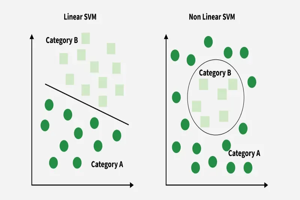

In [62]:
PILprocessed_imgs[0]

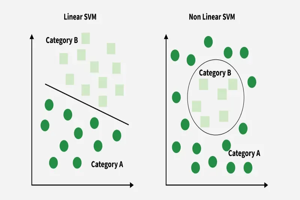

In [63]:
PILprocessed_imgs[0]

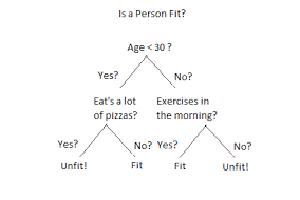

In [64]:
PILprocessed_imgs[1]

In [65]:
ImgDataset = CifarDataset(PILprocessed_imgs, processor)
ImgDataloader = DataLoader(ImgDataset, batch_size=1, shuffle=False) 



In [66]:
from tqdm import tqdm
all_embeddings = []

with torch.no_grad():
    for indices, img_pixels in tqdm(ImgDataloader,desc='Processing Images'):
        print(img_pixels.shape)
        img_pixels = img_pixels.to(device)

        features = model.get_image_features(pixel_values=img_pixels)
        if hasattr(features, "pooler_output"):
            features = features.pooler_output
        elif hasattr(features, "image_embeds"):
            features = features.image_embeds
        else:
            features = features
        features /= features.norm(p=2, dim=-1, keepdim=True)

        all_embeddings.append(features.cpu())

Processing Images:   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


Processing Images:  40%|████      | 2/5 [00:00<00:00,  5.18it/s]

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


Processing Images:  80%|████████  | 4/5 [00:00<00:00,  5.96it/s]

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


Processing Images: 100%|██████████| 5/5 [00:00<00:00,  5.78it/s]


In [67]:
index_matrix = torch.cat(all_embeddings).numpy()
print("Indexing complete!")


Indexing complete!


In [68]:

def search_and_display(query, top_k=3):
    inputs = processor(text=[query], return_tensors="pt", padding="max_length").to(device)
    with torch.no_grad():
        text_feat = model.get_text_features(**inputs)
        text_feat = text_feat.pooler_output
        text_feat /= text_feat.norm(p=2, dim=-1, keepdim=True)

    scores = (text_feat.cpu().numpy() @ index_matrix.T)[0]
    print(scores)
    top_indices = scores.argsort()[-top_k:][::-1]

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(top_indices):
        score = scores[idx]
        img = PILprocessed_imgs[idx]

        plt.subplot(1, top_k, i + 1)
        plt.imshow(img)
        plt.title(f"Score: {score:.3f}\nIndex: {idx}")
        plt.axis('off')
    plt.show()



[ 0.01946273 -0.00942003 -0.00016027  0.09614571 -0.0070502 ]


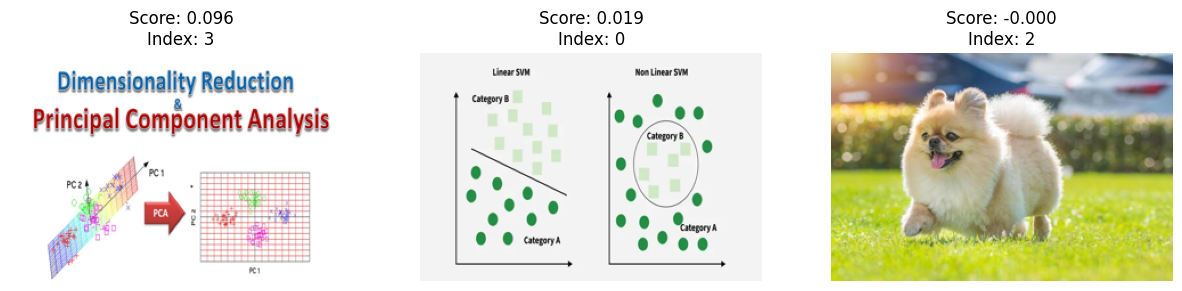

In [73]:
search_and_display('pca')